#Compresion JPEG

Primero se definen algunas funciones que serán necesarias

In [1]:
# python 3.9.5
from math import ceil
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imshow, imread
from collections import Counter
from scipy.fftpack import fft, dct, idct


def zigzag(matrix: np.ndarray) -> np.ndarray:
    """
    computes the zigzag of a quantized block
    :param numpy.ndarray matrix: quantized matrix
    :returns: zigzag vectors in an array
    """
    # initializing the variables
    h = 0
    v = 0
    v_min = 0
    h_min = 0
    v_max = matrix.shape[0]
    h_max = matrix.shape[1]
    i = 0
    output = np.zeros((v_max * h_max))

    while (v < v_max) and (h < h_max):
        if ((h + v) % 2) == 0:  # going up
            if v == v_min:
                output[i] = matrix[v, h]  # first line
                if h == h_max:
                    v = v + 1
                else:
                    h = h + 1
                i = i + 1
            elif (h == h_max - 1) and (v < v_max):  # last column
                output[i] = matrix[v, h]
                v = v + 1
                i = i + 1
            elif (v > v_min) and (h < h_max - 1):  # all other cases
                output[i] = matrix[v, h]
                v = v - 1
                h = h + 1
                i = i + 1
        else:  # going down
            if (v == v_max - 1) and (h <= h_max - 1):  # last line
                output[i] = matrix[v, h]
                h = h + 1
                i = i + 1
            elif h == h_min:  # first column
                output[i] = matrix[v, h]
                if v == v_max - 1:
                    h = h + 1
                else:
                    v = v + 1
                i = i + 1
            elif (v < v_max - 1) and (h > h_min):  # all other cases
                output[i] = matrix[v, h]
                v = v + 1
                h = h - 1
                i = i + 1
        if (v == v_max - 1) and (h == h_max - 1):  # bottom right element
            output[i] = matrix[v, h]
            break
    return output


def trim(array: np.ndarray) -> np.ndarray:
    """
    in case the trim_zeros function returns an empty array, add a zero to the array to use as the DC component
    :param numpy.ndarray array: array to be trimmed
    :return numpy.ndarray:
    """
    trimmed = np.trim_zeros(array, 'b')
    if len(trimmed) == 0:
        trimmed = np.zeros(1)
    return trimmed


def run_length_encoding(array: np.ndarray) -> list:
    """
    finds the intermediary stream representing the zigzags
    format for DC components is <size><amplitude>
    format for AC components is <run_length, size> <Amplitude of non-zero>
    :param numpy.ndarray array: zigzag vectors in array
    :returns: run length encoded values as an array of tuples
    """
    encoded = list()
    run_length = 0
    eob = ("EOB",)

    for i in range(len(array)):
        for j in range(len(array[i])):
            trimmed = trim(array[i])
            if j == len(trimmed):
                encoded.append(eob)  # EOB
                break
            if i == 0 and j == 0:  # for the first DC component
                encoded.append((int(trimmed[j]).bit_length(), trimmed[j]))
            elif j == 0:  # to compute the difference between DC components
                diff = int(array[i][j] - array[i - 1][j])
                if diff != 0:
                    encoded.append((diff.bit_length(), diff))
                else:
                    encoded.append((1, diff))
                run_length = 0
            elif trimmed[j] == 0:  # increment run_length by one in case of a zero
                run_length += 1
            else:  # intermediary steam representation of the AC components
                encoded.append(
                    (run_length, int(trimmed[j]).bit_length(), trimmed[j]))
                run_length = 0
            # send EOB
        if not (encoded[len(encoded) - 1] == eob):
            encoded.append(eob)
    return encoded


def get_freq_dict(array: list) -> dict:
    """
    returns a dict where the keys are the values of the array, and the values are their frequencies
    :param numpy.ndarray array: intermediary stream as array
    :return: frequency table
    """
    #
    data = Counter(array)
    result = {k: d / len(array) for k, d in data.items()}
    return result


def decode_huffman(cod: str, invHuffman: dict) -> list:
    print("decoding huffman...")
    decodingy = []
    index_init = 0
    for index_fin in range(len(cod)):
        if cod[index_init:index_fin] in invHuffman.keys():
            decodingy.append(invHuffman[cod[index_init:index_fin]])
            index_init = index_fin
    print("complete")
    return decodingy


def find_huffman(p: dict) -> dict:
    """
    returns a Huffman code for an ensemble with distribution p
    :param dict p: frequency table
    :returns: huffman code for each symbol
    """
    p_copy = {}
    p_copy2 = {}
    for i in p.keys():
        p_copy[i] = ""
        p_copy2[str(i)] = ""

    while len(p_copy2) >= 2:
        a1, a2 = lowest_prob_pair(p_copy2)
        p1, p2 = p_copy2.pop(a1), p_copy2.pop(a2)

        for i in a1.split("|"):
            if 'EOB' not in i:
                p_copy[tuple(
                    map(int, i.replace('(', '').replace(')', '').split(', ')))] += "1"
            else:
                p_copy[('EOB',)] += "1"

        for i in a2.split("|"):
            if 'EOB' not in i:
                p_copy[tuple(
                    map(int, i.replace('(', '').replace(')', '').split(', ')))] += "0"
            else:
                p_copy[('EOB',)] += "0"

        p_copy2[a1 + "|" + a2] = p1 + p2

    for i in p_copy.keys():
        p_copy[i] = p_copy[i][::-1]
    return p_copy


def lowest_prob_pair(p):
    # Return pair of symbols from distribution p with lowest probabilities
    sorted_p = sorted(p.items(), key=lambda x: x[1])
    return sorted_p[0][0], sorted_p[1][0]


def inv_dct(vBlocksFor_, hBlocksFor_, _Dct, windowSize):
    _IDct = np.zeros((len(_Dct), len(_Dct[0])), np.float32)
    for i in range(vBlocksFor_):
        for j in range(hBlocksFor_):
            # Gets the DCT for each section separated by windowSize spaces
            _IDct[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize] = cv2.idct(
                _Dct[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize])
    return _IDct


def apply_dct(vBlocksFor_, hBlocksFor_, _Padded, _Dct, _q, _Zigzag, windowSize):
    # Calculates the DCT for the component Y of the image
    for i in range(vBlocksFor_):
        for j in range(hBlocksFor_):
            # Gets the DCT for each section separated by windowSize spaces
            _Dct[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize] = cv2.dct(
                _Padded[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize])

            # Once with the DCT then apply the ceil function to get the cuantized values
            _q[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize] = np.round(
                _Dct[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize])

            # Put the matrix form into a vector
            _Zigzag[i * j] += zigzag(_q[i * windowSize: i * windowSize +
                                     windowSize, j * windowSize: j * windowSize + windowSize])


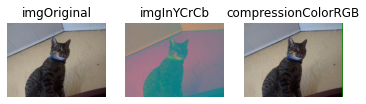

Compression Ratio is 7.4
decoding huffman...
complete
[(14, 10071), (0, 9, 449), (0, 8, -191), (0, 5, 27), (0, 6, 52), (0, 8, 197), (0, 7, 83), (0, 8, 184), (0, 8, -179), (0, 6, -61), (0, 5, -19), (0, 7, -101), (0, 7, -96), (0, 4, 14), (0, 4, 10), (0, 8, -178), (0, 6, 45), (0, 6, 35), (0, 7, -70), (0, 1, 1)]


In [2]:
# python 3.9.5
from PIL import Image as im
from cv2 import line
from functions import *
from collections import Counter
from skimage.io import imshow, imread
import matplotlib.pyplot as plt
import numpy as np
import cv2
from math import ceil

# define window size
windowSize = 8

# read image
imgOriginal = imread('C:\\Users\\Usuario\\Desktop\\JPEG compresor\\migato.png')


# convert BGR to YCrCb
imgInYCrCb = cv2.cvtColor(imgOriginal, cv2.COLOR_BGR2YCrCb)
width = len(imgInYCrCb[0])
height = len(imgInYCrCb)
y = np.zeros((height, width), np.float32) + imgInYCrCb[:, :, 0]
cr = np.zeros((height, width), np.float32) + imgInYCrCb[:, :, 1]
cb = np.zeros((height, width), np.float32) + imgInYCrCb[:, :, 2]

# size of the image in bits before compression
totalNumberOfBitsWithoutCompression = len(
    y) * len(y[0]) * 8 + len(cb) * len(cb[0]) * 8 + len(cr) * len(cr[0]) * 8

# 4: 2: 2 subsampling is used
# another subsampling scheme can be used
# thus chrominance channels should be sub-sampled
# define subsampling factors in both horizontal and vertical directions
SSH, SSV = 2, 2

# filter the chrominance channels using a 2x2 averaging filter # another type of filter can be used
crSub = cr[::SSV, ::SSH]
cbSub = cb[::SSV, ::SSH]

# check if padding is needed,
# if yes define empty arrays to pad each channel DCT with zeros if necessary
yWidth, yLength = ceil(len(y[0]) / windowSize) * \
    windowSize, ceil(len(y) / windowSize) * windowSize

if (len(y[0]) % windowSize == 0) and (len(y) % windowSize == 0):
    yPadded = y.copy()
else:
    yPadded = np.zeros((yLength, yWidth))
    for i in range(len(y)):
        for j in range(len(y[0])):
            yPadded[i, j] += y[i, j]

# chrominance channels have the same dimensions, meaning both can be padded in one loop
cWidth, cLength = ceil(len(cbSub[0]) / windowSize) * \
    windowSize, ceil(len(cbSub) / windowSize) * windowSize

if (len(cbSub[0]) % windowSize == 0) and (len(cbSub) % windowSize == 0):
    crPadded = crSub.copy()
    cbPadded = cbSub.copy()
# since chrominance channels have the same dimensions, one loop is enough
else:
    crPadded = np.zeros((cLength, cWidth))
    cbPadded = np.zeros((cLength, cWidth))
    for i in range(len(crSub)):
        for j in range(len(crSub[0])):
            crPadded[i, j] += crSub[i, j]
            cbPadded[i, j] += cbSub[i, j]


compressionColor = np.zeros((len(yPadded), len(yPadded[0]), 3), np.float32)
for i in range(len(yPadded)):
    for j in range(len(yPadded[0])):
        try:
            compressionColor[i, j, 0] = yPadded[i, j]
            compressionColor[i, j, 1] = crPadded[i//2, j//2]
            compressionColor[i, j, 2] = cbPadded[i//2, j//2]
        except IndexError:
            continue

compressionColorRGB = cv2.cvtColor(
    compressionColor.astype(np.uint8), cv2.COLOR_YCrCb2BGR)


# get DCT of each channel
# define three empty matrices
yDct, crDct, cbDct = np.zeros((yLength, yWidth)), np.zeros(
    (cLength, cWidth)), np.zeros((cLength, cWidth))

# number of iteration on x axis and y axis to calculate the luminance cosine transform values
# number of blocks in the horizontal direction for luminance
hBlocksForY = int(len(yDct[0]) / windowSize)
# number of blocks in the vertical direction for luminance
vBlocksForY = int(len(yDct) / windowSize)
# number of iteration on x axis and y axis to calculate the chrominance channels cosine transforms values
# number of blocks in the horizontal direction for chrominance
hBlocksForC = int(len(crDct[0]) / windowSize)
# number of blocks in the vertical direction for chrominance
vBlocksForC = int(len(crDct) / windowSize)

# define 3 empty matrices to store the quantized values
yq, crq, cbq = np.zeros((yLength, yWidth)), np.zeros(
    (cLength, cWidth)), np.zeros((cLength, cWidth))

# and another 3 for the zigzags
yZigzag = np.zeros(((vBlocksForY * hBlocksForY), windowSize * windowSize))
crZigzag = np.zeros(((vBlocksForC * hBlocksForC), windowSize * windowSize))
cbZigzag = np.zeros(((vBlocksForC * hBlocksForC), windowSize * windowSize))

# Calculates the DCT for the component Y of the image
apply_dct(vBlocksForY, hBlocksForY, yPadded, yDct, yq, yZigzag, windowSize)
# Either crq or cbq can be used to compute the number of blocks
apply_dct(vBlocksForC, hBlocksForC, crPadded, crDct, crq, crZigzag, windowSize)
apply_dct(vBlocksForC, hBlocksForC, cbPadded, cbDct, cbq, cbZigzag, windowSize)


# set type for the zigzag vector
yZigzag = yZigzag.astype(np.int16)
# set type for the zigzag vector
crZigzag = crZigzag.astype(np.int16)
cbZigzag = cbZigzag.astype(np.int16)

# find the run length encoding for each channel
# then get the frequency of each component in order to form a Huffman dictionary

yEncoded = run_length_encoding(yZigzag)
yFrequencyTable = get_freq_dict(yEncoded)
yHuffman = find_huffman(yFrequencyTable)

crEncoded = run_length_encoding(crZigzag)
crFrequencyTable = get_freq_dict(crEncoded)
crHuffman = find_huffman(crFrequencyTable)

cbEncoded = run_length_encoding(cbZigzag)
cbFrequencyTable = get_freq_dict(cbEncoded)
cbHuffman = find_huffman(cbFrequencyTable)

# calculate the number of bits to transmit for each channel
# and write them to an output file

yBitsToTransmit = []
for value in yEncoded:
    yBitsToTransmit.append(yHuffman[value])

crBitsToTransmit = []
for value in crEncoded:
    crBitsToTransmit.append(crHuffman[value])

cbBitsToTransmit = []
for value in cbEncoded:
    cbBitsToTransmit.append(cbHuffman[value])


# show imge
plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(imgOriginal)
plt.axis('off')
plt.title('imgOriginal')

plt.subplot(1, 3, 2)
plt.imshow(imgInYCrCb)
plt.axis('off')
plt.title('imgInYCrCb')

plt.subplot(1, 3, 3)
plt.imshow(compressionColorRGB)
plt.axis('off')
plt.title('compressionColorRGB')

plt.show()

yrealBits = "".join(yBitsToTransmit)
crrealBits = "".join(crBitsToTransmit)
cbrealBits = "".join(cbBitsToTransmit)

file = open("CompressedImage.asfh", "w")
if file.writable():
    file.write(yrealBits + "\n" + crrealBits + "\n" + cbrealBits)
file.close()

totalNumberOfBitsAfterCompression = len(yrealBits) + len(crrealBits) + len(cbrealBits)
print("Compression Ratio is " + str(np.round(totalNumberOfBitsWithoutCompression/totalNumberOfBitsAfterCompression, 1)))


#Descompresion -----------------

invyHuffman = {}
for i in yHuffman.keys():
    invyHuffman[yHuffman[i]] = i

invcrHuffman = {}
for i in crHuffman.keys():
    invcrHuffman[crHuffman[i]] = i

invcbHuffman = {}
for i in cbHuffman.keys():
    invcbHuffman[cbHuffman[i]] = i

decodeFile = open("CompressedImage.asfh", "r")
yread = decodeFile.readline()
crread = decodeFile.readline()
cbread = decodeFile.readline()
decodeFile.close()

ydecoded = decode_huffman(yread,invyHuffman)
print(ydecoded[0:20])
# crdecoded = decode_huffman(crread,invcrHuffman)
# cbdecoded = decode_huffman(cbread,invcbHuffman)






